In [18]:
import os
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd


In [19]:
path_root_data = os.path.join('..', 'Data')
path_anscombes_quartet = os.path.join(path_root_data, 'Anscombes_Quartet.csv')

df_anscombes_quartet = pd.read_csv(path_anscombes_quartet)
df_anscombes_quartet

,x1,y1,x2,y2,x3,y3,x4,y4
0,10.0,8.04,10.0,9.14,10.0,7.46,8.0,6.58
1,8.0,6.95,8.0,8.14,8.0,6.77,8.0,5.76
2,13.0,7.58,13.0,8.74,13.0,12.74,8.0,7.71
3,9.0,8.81,9.0,8.77,9.0,7.11,8.0,8.84
4,11.0,8.33,11.0,9.26,11.0,7.81,8.0,8.47
5,14.0,9.96,14.0,8.10,14.0,8.84,8.0,7.04
6,6.0,7.24,6.0,6.13,6.0,6.08,8.0,5.25
7,4.0,4.26,4.0,3.10,4.0,5.39,19.0,12.50
8,12.0,10.84,12.0,9.13,12.0,8.15,8.0,5.56
9,7.0,4.82,7.0,7.26,7.0,6.42,8.0,7.91


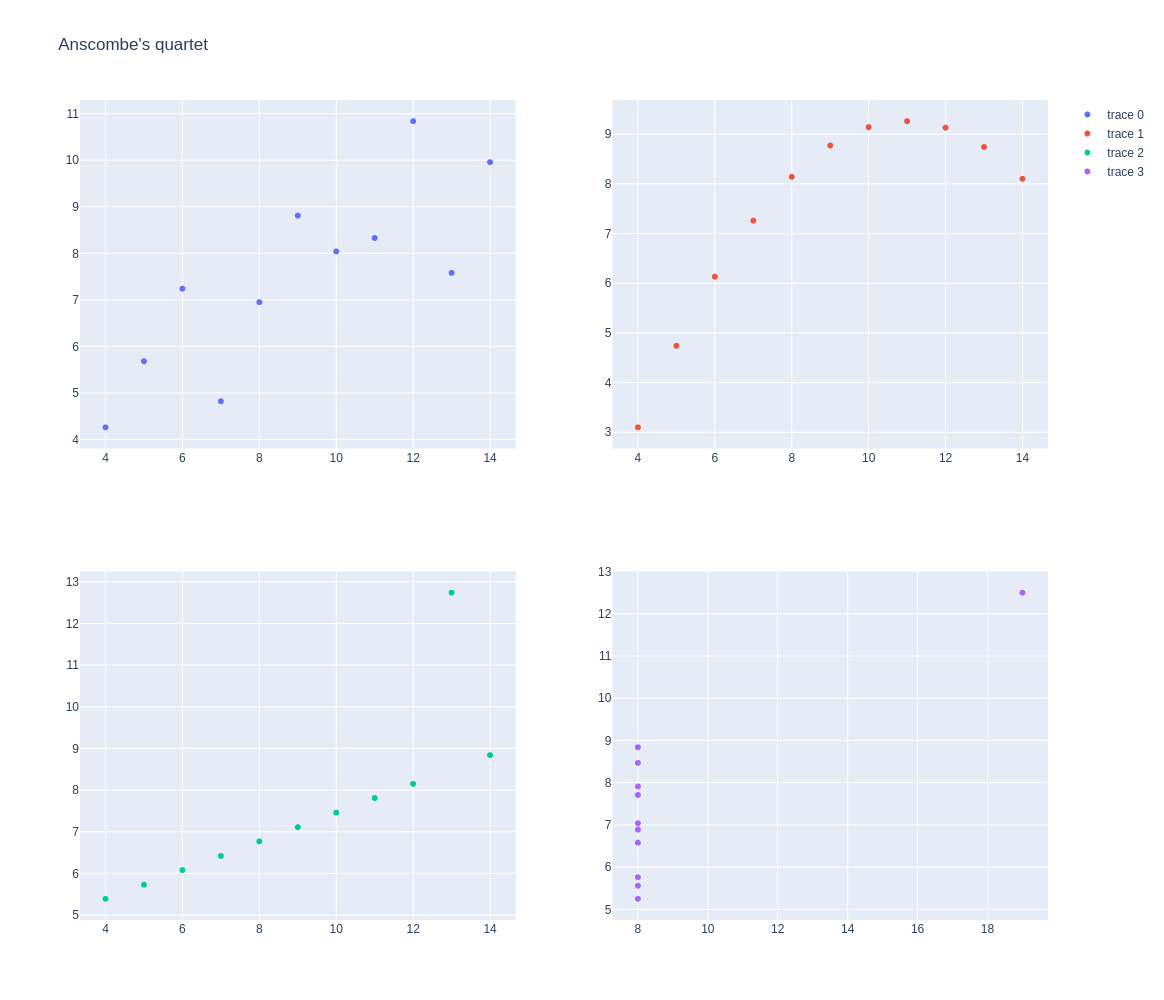

In [20]:
def chart_scatter_anscombes_quartet(df_input):
    
    chart_result = make_subplots(rows=2, cols=2)

    chart_result.add_trace(
        go.Scatter(x=df_input['x1'], y=df_input['y1'], mode="markers"),
        row=1, col=1
    )
    
    chart_result.add_trace(
        go.Scatter(x=df_input['x2'], y=df_input['y2'], mode="markers"),
        row=1, col=2
    )
    
    chart_result.add_trace(
        go.Scatter(x=df_input['x3'], y=df_input['y3'], mode="markers"),
        row=2, col=1
    )
    
    chart_result.add_trace(
        go.Scatter(x=df_input['x4'], y=df_input['y4'], mode="markers"),
        row=2, col=2
    )
    
    chart_result.update_layout(height=1000, title_text="Anscombe's quartet")
    
    return chart_result


chart_anscombes = chart_scatter_anscombes_quartet(df_anscombes_quartet)
chart_anscombes.show()
    

In [21]:
df_anscombes_quartet.columns.to_list()

['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4']

In [22]:
df_anscombes_quartet_modified = df_anscombes_quartet.drop(
    ['x1', 'x2', 'x3', 'x4'], axis=1)
df_anscombes_quartet_modified

,y1,y2,y3,y4
0,8.04,9.14,7.46,6.58
1,6.95,8.14,6.77,5.76
2,7.58,8.74,12.74,7.71
3,8.81,8.77,7.11,8.84
4,8.33,9.26,7.81,8.47
5,9.96,8.10,8.84,7.04
6,7.24,6.13,6.08,5.25
7,4.26,3.10,5.39,12.50
8,10.84,9.13,8.15,5.56
9,4.82,7.26,6.42,7.91


In [75]:
import math
from sklearn.neighbors import KernelDensity
from sklearn.metrics import mean_squared_error
from shannon import continuous
from npeet import entropy_estimators
from scipy.stats import differential_entropy
from sklearn.feature_selection import mutual_info_regression


# Implement bookmarked solutions for entropy and MI estimation
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html?highlight=entropy
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.differential_entropy.html
# https://github.com/paulbrodersen/entropy_estimators/
# https://github.com/gregversteeg/NPEET <- USE THIS ONE FIRST !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# https://github.com/BiuBiuBiLL/NPEET_LNC <- And this one second (an improvement)

def calculate_td_properties(df_input, string_reference_feature,
                             string_method='pearson'):
    
    list_all_features = df_input.columns.to_list()
    list_not_reference_features = [i for i in list_all_features
                                   if i != string_reference_feature]
    
    # Initialize dict
    dict_result = {}
    for string_one_feature in list_all_features:
        dict_result[string_one_feature] = []
    
    # IMPORTANT NOTE: Authors of MID paper were using correlation corr(xi,yi)
    # for i in {1,2,3,4} instead of corr(y4, yi) for i in {1,2,3}
    # That is why my plot is different. Their example is bad since in MID
    # they are comparing different yi for fixed x (time-series)
    # and for Taylor diagram they did the opposite in order to create an example
    # that fits their narrative
    
    for string_one_feature in list_all_features:
        # Calculating standard deviations
        dict_result[string_one_feature].append(
            df_input[string_one_feature].std(ddof=0))
        
        # Calculating Pearson's correlation
        dict_result[string_one_feature].append(
            df_input[string_reference_feature].corr(
                df_input[string_one_feature], method=string_method))
        
        # Calculate arccos of Pearson's correlation
        dict_result[string_one_feature].append(math.degrees(
            math.acos(dict_result[string_one_feature][-1])))
        
        # Calculating RMS
        dict_result[string_one_feature].append(
            mean_squared_error(
                df_input[string_reference_feature],
                df_input[string_one_feature], squared=False)
        )
    
    for string_one_feature in list_all_features:
        # Calculating correlation using RMS formula
        #dict_result[string_one_feature].append(
        #    (dict_result[string_one_feature][0]**2 + dict_result[string_reference_feature][0]**2 - dict_result[string_one_feature][3]**2) / (2 * dict_result[string_one_feature][0] * dict_result[string_reference_feature][0])
        #)
        
        # Calculating the angle using calculated correlation
        #dict_result[string_one_feature].append(math.degrees(
        #    math.acos(dict_result[string_one_feature][-1])))
        
        # Normalizing the RMS as in the paper
        dict_result[string_one_feature].append(
            dict_result[string_one_feature][3] /
            dict_result[string_reference_feature][0])
        
        # Calculating normalized standard deviation
        dict_result[string_one_feature].append(
            dict_result[string_one_feature][0] / dict_result[
                string_reference_feature][0])
    
    
    df_result = pd.DataFrame().from_dict(
        dict_result, orient='index',
        #columns=['STD', 'Correlation', 'Angle', 'RMS', 'Calculated_Corr',
        #         'Calculated_Angle', 'Normalized_RMS', 'Normalized_STD']
        columns=['STD', 'Correlation', 'Angle', 'RMS', 'Normalized_RMS',
                 'Normalized_STD']
    )
    
    df_result = df_result.reset_index().rename(columns={'index': 'Model'})
    
    return df_result


def list_adapt_to_npeet(list_input):
    return [[i] for i in list_input]


def calculate_mid_properties(df_input, string_reference_feature,
                             string_library):
    
    list_all_features = df_input.columns.to_list()
    list_not_reference_features = [i for i in list_all_features
                                   if i != string_reference_feature]
    
    list_adapted_npeet_reference = list_adapt_to_npeet(
        df_input[string_reference_feature])
    
    # Initialize dict
    dict_result = {}
    for string_one_feature in list_all_features:
        dict_result[string_one_feature] = []
    
    
    # TODO: Entropies are negative often when using default parameters
    # That is causing an error when calculating angles
    # Try to find better default parameters so it doesn't happen
    for string_one_feature in list_all_features:
        list_adapted_npeet_one = list_adapt_to_npeet(
            df_input[string_one_feature])
        
        if string_library == 'scipy_sklearn':
            # Calculate entropies
            # 0 in the list
            dict_result[string_one_feature].append(
                differential_entropy(df_input[string_one_feature], base=2))
            #dict_result[string_one_feature].append(
            #    mutual_info_regression(
            #        df_input[string_one_feature].to_numpy().reshape(-1, 1),
            #        df_input[string_one_feature],
            #        discrete_features=False)[0])
            
            # Calculate mutual informations against the reference feature
            # 1 in the liststring_angular_column
            dict_result[string_one_feature].append(
                mutual_info_regression(
                    df_input[string_reference_feature].to_numpy().reshape(-1, 1),
                    df_input[string_one_feature],
                    discrete_features=False)[0])
            
        
        elif string_library == 'npeet':
            # Calculate entropies
            # 0 in the list
            dict_result[string_one_feature].append(
                entropy_estimators.entropy(list_adapted_npeet_one))
            
            # Calculate mutual informations against the reference feature
            # 1 in the liststring_angular_column
            dict_result[string_one_feature].append(
                entropy_estimators.mi(list_adapted_npeet_reference,
                                      list_adapted_npeet_one))
        
        else:
            print('BAD LIB ARGUMENT')
            return None
            
        
    for string_one_feature in list_all_features:
        # Calculating fixed MI from equation 17 from the paper
        # I(X,Y) = I~(X,Y) * (H(X) / I~(X,X)) where I~ is MI calculated using
        # some estimation method. This MI is used for every calculation
        # afterwards
        # 2 in the list
        dict_result[string_one_feature].append(
            dict_result[string_one_feature][1] *
            (dict_result[string_reference_feature][0] /
             dict_result[string_reference_feature][1])
        )
        
        # Calculate scaled entropies
        # 3 in the list
        dict_result[string_one_feature].append(
            dict_result[string_one_feature][0] /
            dict_result[string_reference_feature][0]
        )

        # Calculate normalized mutual information according to the paper
        # NMI(X,Y) = I(X,Y) / sqrt(H(X) * H(Y))
        # This has to be modified because H(X)*H(Y) can be negative for
        # differential entropies. NMI is not used at all for the MI chart
        # that spans two quadrants
        # 4 in the list
        float_product = dict_result[string_reference_feature][0] *\
            dict_result[string_one_feature][0]
        
        if float_product < 0:
            dict_result[string_one_feature].append(1)
        
        else:
            dict_result[string_one_feature].append(
                dict_result[string_one_feature][2] / math.sqrt(float_product))
        
        # Calculate arccos of normalized mutual information according to the
        # paper arccos(NMI(X,Y))
        # 5 in the list
        dict_result[string_one_feature].append(
            math.degrees(math.acos(dict_result[string_one_feature][4])))
    
    
    for string_one_feature in list_all_features:
        ######################################################################
        # This part is for the chart that spans two quadrants
        
        # First calculate joint entropies by using equation 10 from the paper
        # I(X,Y) = H(X) + H(Y) - H(X,Y) => H(X,Y) = H(X) + H(Y) - I(X,Y)
        # 6 in the list
        dict_result[string_one_feature].append(
            dict_result[string_reference_feature][0] +
            dict_result[string_one_feature][0] -
            dict_result[string_one_feature][2]
        )
        
        # Calculate scaled mutual information according to the paper
        # SMI(X,Y) = I(X,Y) * ((H(X,Y) / (H(X)*H(Y)))) (equation 15)
        # 7 in the list
        smi_x_y = dict_result[string_one_feature][2] * (
            dict_result[string_one_feature][6] /
            (dict_result[string_reference_feature][0]
             * dict_result[string_one_feature][0]))
        
        dict_result[string_one_feature].append(smi_x_y)
        
        # Calculate arccos of biased scaled mutual information according to the paper
        # arccos(c(X,Y)) where c(X,Y) = 2*SMI(X,Y) - 1
        # 8 in the list
        float_c_x_y = 2*smi_x_y - 1
        
        if float_c_x_y > 1:
            dict_result[string_one_feature].append(
                math.degrees(math.acos(1)))
        elif float_c_x_y < -1:
            dict_result[string_one_feature].append(
            math.degrees(math.acos(-1)))
        else:
            dict_result[string_one_feature].append(
                math.degrees(math.acos(float_c_x_y)))
        
        # Calculate root entropy
        # 9 in the list
        if dict_result[string_one_feature][0] >= 0:
            float_root_entropy = math.sqrt(dict_result[string_one_feature][0])
        else:
            float_root_entropy = -1
        
        dict_result[string_one_feature].append(float_root_entropy)
        ######################################################################
    
    df_result = pd.DataFrame().from_dict(
        dict_result, orient='index',
        columns=['Entropy', 'Mutual_information', 'Fixed_MI', 'Scaled_entropy',
                 'Normalized_MI', 'Angle_NMI', 'Joint_entropies', 'Scaled_MI',
                 'Angle_SMI', 'Root_Entropy'])
    
    df_result = df_result.reset_index().rename(columns={'index': 'Model'})
    
    return df_result



def chart_create_mid(df_input, string_reference_feature,
                     string_type='scaled'):
    
    np_tmp = np.array(
        [0, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1.0])
    
    if string_type == 'scaled':
        np_angular_labels = np.concatenate((-np_tmp[:0:-1], np_tmp))
        np_angular_ticks = np.degrees(np.arccos(np_angular_labels))
        np_angular_labels = np.round((np_angular_labels + 1) / 2, 3)
        
        list_sector = [0, 180]
        string_angular_column = 'Angle_SMI'
        string_radial_column = 'Entropy'
    
    elif string_type == 'normalized':
        np_angular_labels = np_tmp
        np_angular_ticks = np.degrees(np.arccos(np_angular_labels))
        
        list_sector = [0, 90]
        string_angular_column = 'Angle_NMI'
        string_radial_column = 'Root_Entropy'
        
    else:
        raise('Type has to be either "scaled" or "normalized"')
        return None
    
    float_max_r = df_input[string_radial_column].max() +\
        df_input[string_radial_column].mean()
    
    chart_result = px.scatter_polar(
        data_frame=df_input,
        start_angle=0,
        color='Model',
        r=string_radial_column,
        range_r=[0, float_max_r],
        theta=string_angular_column,
        title='Mutual Information Diagram',
        #labels={'Entropy': 'Entropy', 'Normalized MI': 'NMI'}

    )

    chart_result.update_layout(
        polar = dict(
            sector = list_sector,
            angularaxis = dict(
                #thetaunit = "degrees",
                #dtick = 10,
                #rotation=270,
                direction = "counterclockwise",
                #tickmode="array",
                tickvals=np_angular_ticks,
                ticktext=np_angular_labels
                )
        ),
        height=600
    )
    
    chart_result.update_polars(
        radialaxis_title_text=string_radial_column,
    )
    
    return chart_result


def chart_create_td(df_input, string_reference_feature):
    
    string_radial_column = 'STD'
    string_angular_column = 'Angle'
    float_max_r = df_input[string_radial_column].max() +\
        df_input[string_radial_column].mean()
    
    chart_result = px.scatter_polar(
        data_frame=df_input,
        start_angle=0,
        color='Model',
        r=string_radial_column,
        range_r=[0, float_max_r],
        theta=string_angular_column,
        title='Taylor Diagram',
        #labels={'Normalized_STD': 'Normalized STD', 'Angle': 'Correlation'}
    )
    
    bool_only_half = True if (df_input[string_angular_column] <= 90).all() else False
    int_max_angle = 90 if bool_only_half else 180
    int_min_corr_value = 0 if bool_only_half else -1
    
    np_tmp = np.array([0, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1.0])
    if bool_only_half:
        np_angular_labels = np_tmp
    else:
        np_angular_labels = np.concatenate((-np_tmp[:0:-1], np_tmp))
    
    np_angular_ticks = np.degrees(np.arccos(np_angular_labels))
    
    chart_result.update_layout(
        polar = dict(
            sector=[0, int_max_angle],
            angularaxis=dict(
                #thetaunit = "degrees",
                #dtick=10,
                #rotation=270,
                direction="counterclockwise",
                #tickmode="array",
                tickvals=np_angular_ticks,
                ticktext=np_angular_labels,
            ),
        ),
        height=600
    )
    
    chart_result.update_polars(
        radialaxis_title_text=string_radial_column,
    )
    
    return chart_result


string_ref_model = 'y4'
string_type_mid = 'scaled'


df_taylor_res = calculate_td_properties(df_anscombes_quartet_modified, string_ref_model, string_method='pearson')
print('Taylor')
df_taylor_res

Taylor


,Model,STD,Correlation,Angle,RMS,Normalized_RMS,Normalized_STD
0,y1,1.937024,-0.489116,119.282510,3.342016,1.726176,1.000487
1,y2,1.937109,-0.478095,118.561047,3.329698,1.719814,1.000531
2,y3,1.935933,-0.155472,98.944159,2.943077,1.520121,0.999924
3,y4,1.936081,1.000000,0.000000,0.000000,0.000000,1.000000


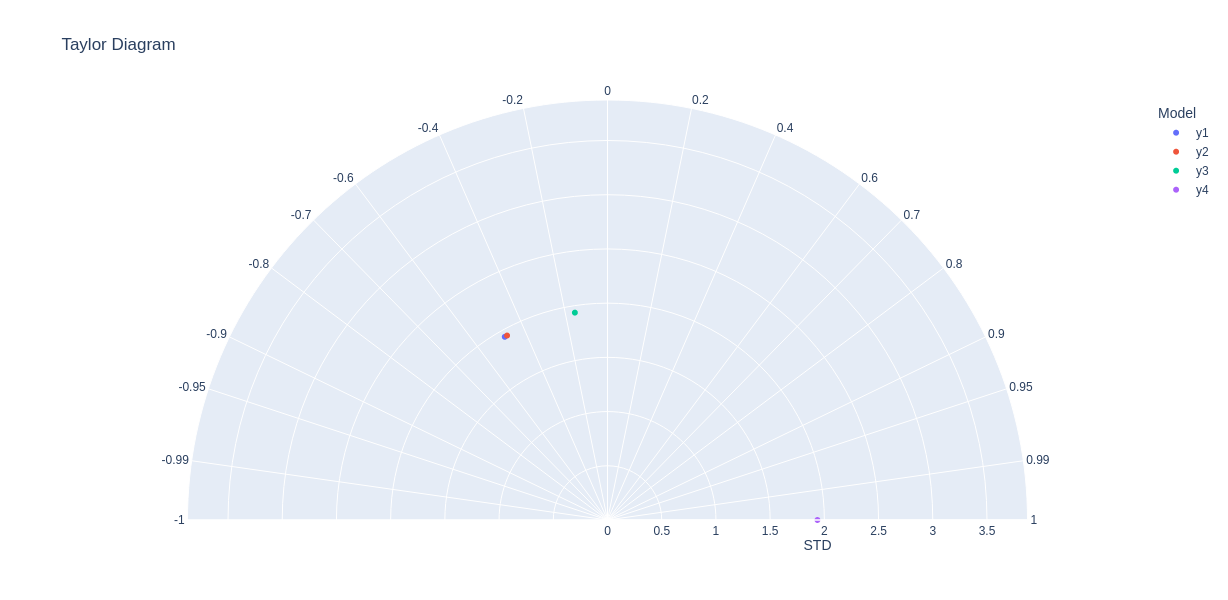

In [76]:
chart_taylor_res = chart_create_td(df_taylor_res, string_ref_model)
chart_taylor_res.show()

In [77]:
#df_mi_res_shannon = calculate_mid_properties_shannon(df_anscombes_quartet_modified, string_ref_model)#, string_method='gaussian')

print('Mutual Information NPEET')
df_mi_res_npeet = calculate_mid_properties(df_anscombes_quartet_modified, string_ref_model, 'npeet')
df_mi_res_npeet

Mutual Information NPEET


,Model,Entropy,Mutual_information,Fixed_MI,Scaled_entropy,Normalized_MI,Angle_NMI,Joint_entropies,Scaled_MI,Angle_SMI,Root_Entropy
0,y1,3.389044,-0.046424,-0.090947,1.094441,-0.028074,91.608753,6.576589,-0.056994,180.0,1.840936
1,y2,2.753054,-0.026647,-0.052203,0.889057,-0.017879,91.024452,5.901855,-0.036140,180.0,1.659233
2,y3,2.929475,-0.049547,-0.097065,0.946030,-0.032227,91.846814,6.123138,-0.065518,180.0,1.711571
3,y4,3.096598,1.580667,3.096598,1.000000,1.000000,0.000000,3.096598,1.000000,0.0,1.759715


In [78]:
print('Mutual Information DEFAULT')
df_mi_res = calculate_mid_properties(df_anscombes_quartet_modified, string_ref_model, 'scipy_sklearn')
df_mi_res

Mutual Information DEFAULT


,Model,Entropy,Mutual_information,Fixed_MI,Scaled_entropy,Normalized_MI,Angle_NMI,Joint_entropies,Scaled_MI,Angle_SMI,Root_Entropy
0,y1,2.852820,0.000000,0.000000,1.052292,0.0,90.0,5.563874,0.0,180.0,1.689029
1,y2,2.312211,0.000000,0.000000,0.852883,0.0,90.0,5.023265,0.0,180.0,1.520596
2,y3,2.618974,0.000000,0.000000,0.966036,0.0,90.0,5.330028,0.0,180.0,1.618325
3,y4,2.711054,1.095635,2.711054,1.000000,1.0,0.0,2.711054,1.0,0.0,1.646528


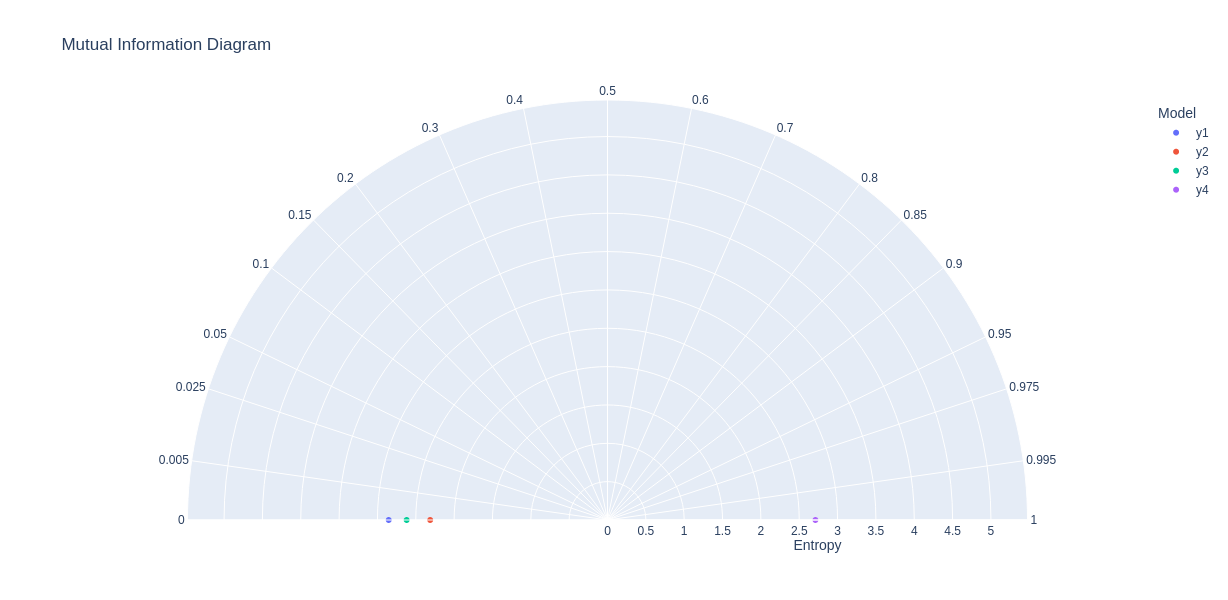

In [79]:
chart_mi_res = chart_create_mid(df_mi_res, string_ref_model, string_type=string_type_mid)
chart_mi_res.show()

In [80]:
import cftime
import datetime as dt
import xarray
from netCDF4 import Dataset, date2index, num2date, date2num

def test_dataset_1():
    
    # IMPORTANT
    ###########################################################################
    # How to generate wget script: https://esgf.github.io/esgf-user-support/faq.html#how-to-preserve-the-directory-structure
    # Link to wget script used here: https://esgf-data.dkrz.de/esg-search/wget?download_structure=model&project=CMIP3&experiment=historical&ensemble=run1&variable=ts
    ###########################################################################
    
    path_root_data = os.path.join('..', 'Data')
    path_dataset_1 = os.path.join(path_root_data, 'Dataset_1', 'Files')
    
    float_kelvin = 273.15
    
    list_datetimes = []
    list_temperatures = []
    list_models = []
    
    # Each name is encoded as a directory name
    list_model_names = [i for i in os.listdir(path_dataset_1)
                        if os.path.isdir(os.path.join(path_dataset_1, i))]
    
    for i, string_one_model in enumerate(list_model_names):
        path_one_model_dir = os.path.join(path_dataset_1, string_one_model)
        
        if string_one_model in ['ncar_ccsm3_0', 'mri_cgcm2_3_2a']:
            continue
        
        for j, string_one_model_file in enumerate(os.listdir(path_one_model_dir)):
        
            path_one_model_file = os.path.join(
                path_one_model_dir, string_one_model_file)
            
            ds_one_model_file = xarray.open_dataset(
                path_one_model_file, decode_times=True, use_cftime=True)
            
            try:
                # Time slicing for the 20th century
                ds_one_model_file_20th_century = ds_one_model_file.sel(
                    time=slice('1900-01-01','2000-01-01'))

                # Anual resampling
                ds_one_model_file_20th_century_mean = ds_one_model_file_20th_century.resample(time='AS').mean()

                ds_one_model_file_temperature = ds_one_model_file_20th_century_mean.variables['ts'].to_numpy()
                ds_one_model_file_time = ds_one_model_file_20th_century_mean.indexes['time'].to_datetimeindex()

                list_datetimes += ds_one_model_file_time.tolist()

                # Taking geographicall mean besides temporal
                np_tmp_temp = np.array(ds_one_model_file_temperature)
                list_geographically_mean_temperatures = np_tmp_temp.mean(axis=(1,2)).tolist()
                list_temperatures += list_geographically_mean_temperatures

                list_models += [string_one_model] * len(list_geographically_mean_temperatures)
            
            except:
                continue
    
    df_dataset_1 = pd.DataFrame(
        {'Datetime': list_datetimes, 'Temperature': list_temperatures,
         'Model': list_models})
    
    return df_dataset_1


df_dataset_1 = test_dataset_1()
df_dataset_1

/tmp/ipykernel_8327/261608704.py:50: RuntimeWarning:

Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.

/tmp/ipykernel_8327/261608704.py:50: RuntimeWarning:

Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.

/tmp/ipykernel_8327/261608704.py:50: RuntimeWarning:

Converting a CFTimeIndex with dates from a non-standard calendar, '360_day', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.

/tmp/ipykernel_8327/261608704.py:50: RuntimeWarning:

Converting a CFTimeIndex with dates from a non-stan

,Datetime,Temperature,Model
0,1900-01-01,277.076477,inmcm3_0
1,1901-01-01,277.123596,inmcm3_0
2,1902-01-01,277.183899,inmcm3_0
3,1903-01-01,277.028564,inmcm3_0
4,1904-01-01,277.259094,inmcm3_0
...,...,...,...
2195,1995-01-01,277.791870,ukmo_hadcm3
2196,1996-01-01,277.680725,ukmo_hadcm3
2197,1997-01-01,277.992981,ukmo_hadcm3
2198,1998-01-01,277.921051,ukmo_hadcm3


In [81]:
df_dataset_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Datetime     2200 non-null   datetime64[ns]
 1   Temperature  2200 non-null   float64       
 2   Model        2200 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 51.7+ KB


In [82]:
df_dataset_1['Model'].unique()

array(['inmcm3_0', 'cccma_cgcm3_1_t63', 'ingv_echam4', 'iap_fgoals1_0_g',
       'miub_echo_g', 'giss_model_e_h', 'gfdl_cm2_1', 'giss_model_e_r',
       'bccr_bcm2_0', 'csiro_mk3_0', 'ukmo_hadgem1', 'gfdl_cm2_0',
       'mpi_echam5', 'miroc3_2_medres', 'ncar_pcm1', 'csiro_mk3_5',
       'giss_aom', 'miroc3_2_hires', 'ipsl_cm4', 'cccma_cgcm3_1',
       'cnrm_cm3', 'ukmo_hadcm3'], dtype=object)

In [83]:
len(df_dataset_1['Model'].unique())

22

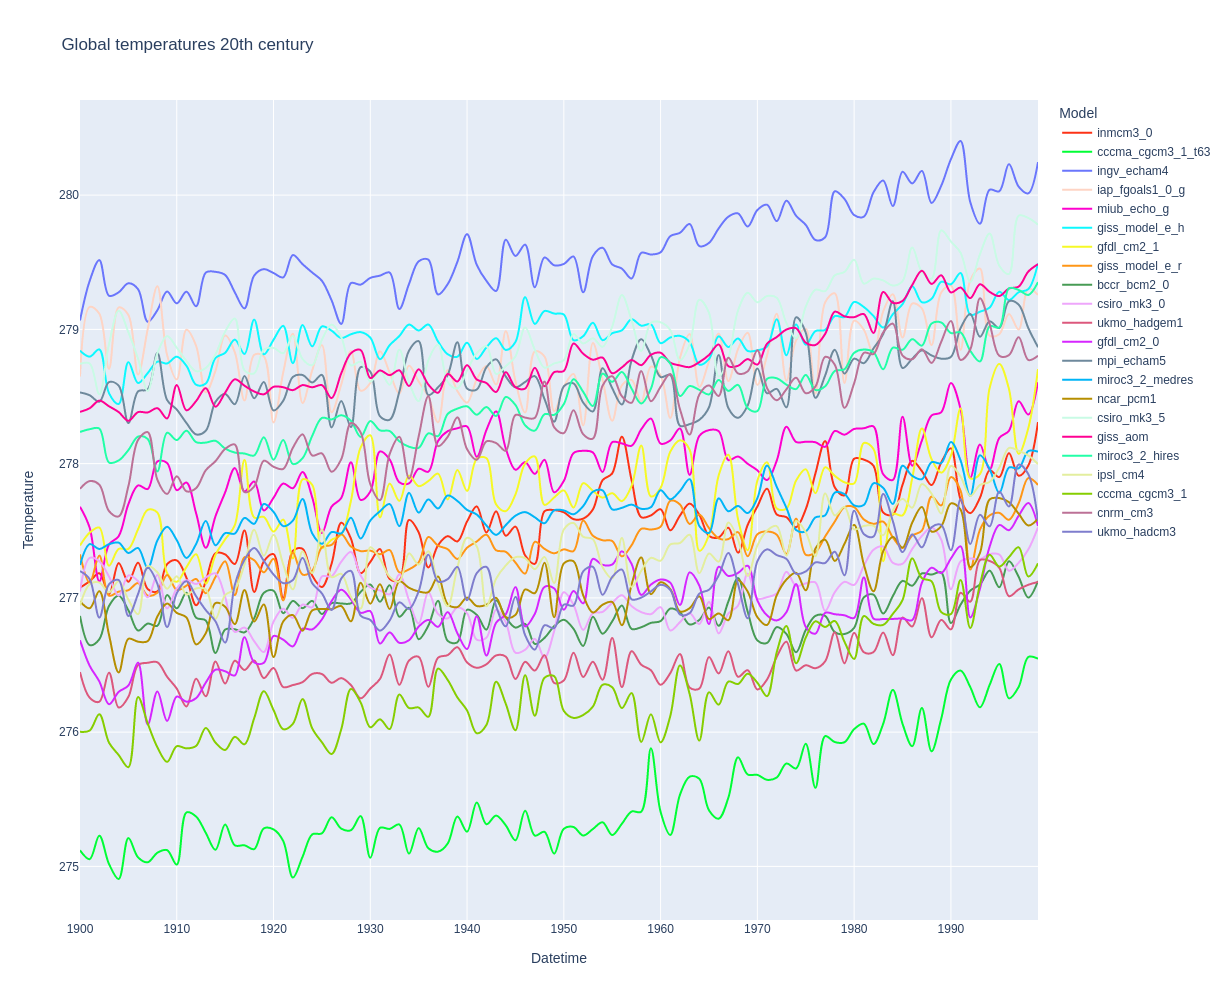

In [84]:
fig = px.line(df_dataset_1, x='Datetime', y='Temperature', color='Model',
              title='Global temperatures 20th century', render_mode='svg',
              line_shape='spline',
              color_discrete_sequence=px.colors.qualitative.Light24,)
fig.update_layout(height=1000)
fig.show()

In [85]:
df_dataset_1_pivoted = pd.pivot(df_dataset_1, index=['Datetime'], columns=['Model'], values=['Temperature']).reset_index(drop=True)
df_dataset_1_pivoted.columns = df_dataset_1_pivoted.columns.get_level_values(1)
df_dataset_1_pivoted

Model,bccr_bcm2_0,cccma_cgcm3_1,cccma_cgcm3_1_t63,cnrm_cm3,csiro_mk3_0,csiro_mk3_5,gfdl_cm2_0,gfdl_cm2_1,giss_aom,giss_model_e_h,...,ingv_echam4,inmcm3_0,ipsl_cm4,miroc3_2_hires,miroc3_2_medres,miub_echo_g,mpi_echam5,ncar_pcm1,ukmo_hadcm3,ukmo_hadgem1
0,276.865601,276.002563,275.119843,277.812378,277.047333,278.742828,276.684692,277.390442,278.385315,278.841309,...,279.066498,277.076477,276.943085,278.235901,277.244904,277.678986,278.530609,276.974762,277.199677,276.447510
1,276.648376,276.011749,275.053864,277.870117,277.297546,278.746216,276.494141,277.485474,278.412415,278.796906,...,279.361145,277.123596,277.102478,278.256470,277.400635,277.522614,278.509583,276.922485,277.139191,276.256592
2,276.692078,276.133514,275.228760,277.842987,277.272705,278.516357,276.377502,277.523804,278.469360,278.850769,...,279.515869,277.183899,277.114075,278.261261,277.363922,277.123749,278.461151,277.050232,276.853088,276.226593
3,276.940002,275.921570,275.017639,277.646393,277.158569,278.891052,276.207672,277.239960,278.427094,278.524261,...,279.250458,277.028564,277.040771,278.007935,277.399963,277.397949,278.607269,276.724640,277.101227,276.443298
4,277.016418,275.829468,274.906097,277.607147,277.016510,279.138519,276.300018,277.364685,278.384064,278.444336,...,279.276093,277.259094,277.124786,278.023560,277.411346,277.459534,278.580688,276.444580,277.132538,276.183167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,277.078735,277.233032,276.508240,278.803253,277.323029,279.473785,277.543152,278.742798,279.248108,279.280243,...,280.028534,277.899567,277.970917,279.014557,277.781433,278.191223,279.009399,277.743652,277.791870,277.224091
96,277.273438,277.303558,276.251526,278.808105,277.202087,279.412689,277.504211,278.555969,279.304291,279.218414,...,280.230988,278.078400,278.116333,279.305420,277.970764,278.244751,279.209564,277.712982,277.680725,277.012482
97,277.156433,277.377502,276.336853,278.942139,277.261566,279.846802,277.612183,278.072968,279.318207,279.276794,...,280.062958,277.909790,278.096161,279.293823,277.964844,278.465179,279.184357,277.626801,277.992981,277.063293
98,277.002075,277.158752,276.559875,278.771912,277.361115,279.829834,277.706665,278.265320,279.430756,279.299530,...,280.013428,277.985931,278.060577,279.256287,278.093384,278.365509,279.009308,277.539246,277.921051,277.097687


In [86]:
df_dataset_1_mid = calculate_mid_properties(df_dataset_1_pivoted, 'bccr_bcm2_0', 'scipy_sklearn')
df_dataset_1_mid

,Model,Entropy,Mutual_information,Fixed_MI,Scaled_entropy,Normalized_MI,Angle_NMI,Joint_entropies,Scaled_MI,Angle_SMI,Root_Entropy
0,bccr_bcm2_0,-0.731772,3.344044,-0.731772,1.000000,-1.000000,180.000000,-0.731772,1.000000,0.000001,-1.000000
1,cccma_cgcm3_1,0.491545,0.200957,-0.043975,-0.671718,1.000000,0.000000,-0.196252,-0.023993,180.000000,0.701102
2,cccma_cgcm3_1_t63,0.408123,0.143735,-0.031453,-0.557719,1.000000,0.000000,-0.292196,-0.030773,180.000000,0.638845
3,cnrm_cm3,0.565183,0.178099,-0.038973,-0.772348,1.000000,0.000000,-0.127616,-0.012026,180.000000,0.751786
4,csiro_mk3_0,-0.196525,0.131913,-0.028866,0.268560,-0.076119,94.365548,-0.899430,0.180537,129.711736,-1.000000
5,csiro_mk3_5,0.257756,0.131548,-0.028786,-0.352235,1.000000,0.000000,-0.445230,-0.067950,180.000000,0.507697
6,gfdl_cm2_0,0.417713,0.088154,-0.019291,-0.570823,1.000000,0.000000,-0.294769,-0.018603,180.000000,0.646307
7,gfdl_cm2_1,0.388671,0.000000,-0.000000,-0.531137,1.000000,0.000000,-0.343100,-0.000000,180.000000,0.623435
8,giss_aom,0.026597,0.194888,-0.042647,-0.036346,1.000000,0.000000,-0.662528,-1.451739,180.000000,0.163085
9,giss_model_e_h,-0.323224,0.142521,-0.031188,0.441701,-0.064127,93.676744,-1.023809,0.134996,136.887035,-1.000000


In [91]:
df_dataset_1_mid = calculate_mid_properties(df_dataset_1_pivoted, 'bccr_bcm2_0', 'npeet')
df_dataset_1_mid

,Model,Entropy,Mutual_information,Fixed_MI,Scaled_entropy,Normalized_MI,Angle_NMI,Joint_entropies,Scaled_MI,Angle_SMI,Root_Entropy
0,bccr_bcm2_0,-0.517006,4.824436,-0.517006,1.000000,-1.000000,180.000000,-0.517006,1.000000,0.000000,-1.000000
1,cccma_cgcm3_1,0.487523,0.150130,-0.016089,-0.942974,1.000000,0.000000,-0.013394,-0.000855,180.000000,0.698229
2,cccma_cgcm3_1_t63,0.283946,0.225622,-0.024179,-0.549213,1.000000,0.000000,-0.208881,-0.034403,180.000000,0.532866
3,cnrm_cm3,0.680123,0.241768,-0.025909,-1.315505,1.000000,0.000000,0.189026,0.013928,166.444671,0.824696
4,csiro_mk3_0,-0.036218,0.192487,-0.020628,0.070054,-0.150744,98.670041,-0.532596,0.586715,80.012738,-1.000000
5,csiro_mk3_5,0.505146,0.077967,-0.008355,-0.977060,1.000000,0.000000,-0.003505,-0.000112,180.000000,0.710736
6,gfdl_cm2_0,0.497832,0.220792,-0.023661,-0.962914,1.000000,0.000000,0.004487,0.000413,177.672450,0.705572
7,gfdl_cm2_1,0.670256,0.155242,-0.016636,-1.296419,1.000000,0.000000,0.169887,0.008156,169.636987,0.818692
8,giss_aom,0.012451,0.175223,-0.018778,-0.024083,1.000000,0.000000,-0.485777,-1.417014,180.000000,0.111584
9,giss_model_e_h,-0.340753,0.226809,-0.024306,0.659090,-0.057908,93.319759,-0.833453,0.114989,140.355954,-1.000000


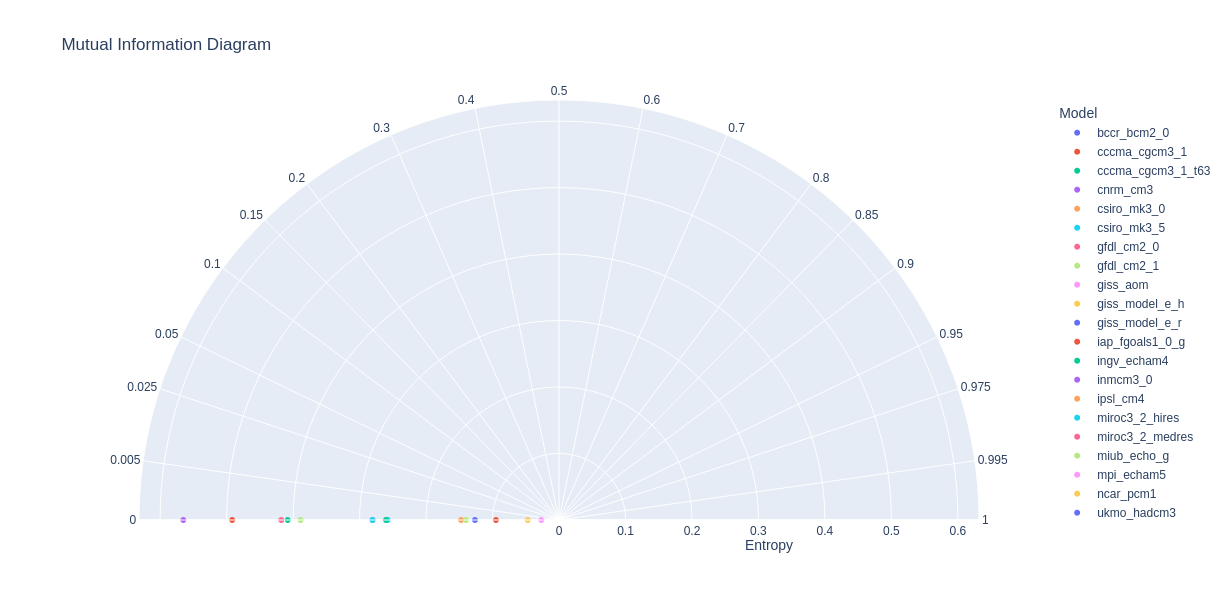

In [87]:
chart_mi_res = chart_create_mid(df_dataset_1_mid, 'bccr_bcm2_0', string_type=string_type_mid)
chart_mi_res.show()

In [88]:
df_dataset_1_td = calculate_td_properties (df_dataset_1_pivoted, 'bccr_bcm2_0')
df_dataset_1_td

,Model,STD,Correlation,Angle,RMS,Normalized_RMS,Normalized_STD
0,bccr_bcm2_0,0.150708,1.000000,0.000000,0.000000,0.000000,1.000000
1,cccma_cgcm3_1,0.421117,0.447744,63.400940,0.651690,4.324178,2.794250
2,cccma_cgcm3_1_t63,0.426046,0.408067,65.916517,1.429422,9.484678,2.826955
3,cnrm_cm3,0.381168,0.231036,76.641935,1.518590,10.076338,2.529172
4,csiro_mk3_0,0.217599,0.456389,62.845662,0.246113,1.633043,1.443843
5,csiro_mk3_5,0.329518,0.434916,64.220078,2.148455,14.255701,2.186457
6,gfdl_cm2_0,0.339364,0.246686,75.718534,0.336084,2.230024,2.251791
7,gfdl_cm2_1,0.328633,0.250612,75.486247,0.952518,6.320265,2.180585
8,giss_aom,0.298304,0.407816,65.932268,1.915679,12.711158,1.979344
9,giss_model_e_h,0.191953,0.327887,70.859409,2.085016,13.834764,1.273673


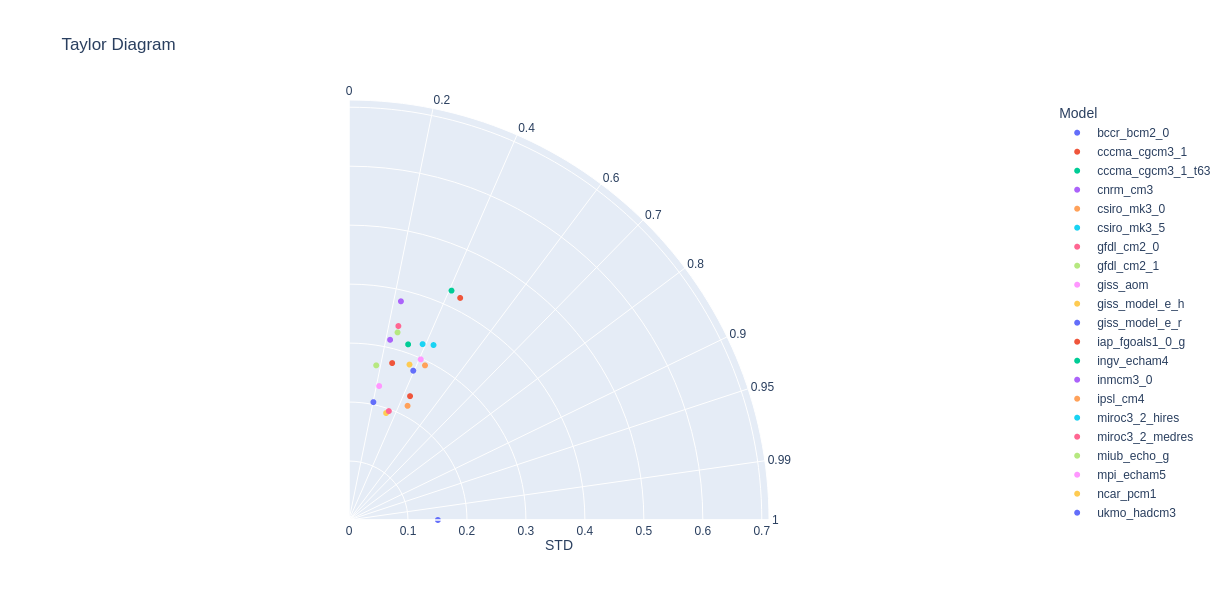

In [89]:
chart_td_res = chart_create_td(df_dataset_1_td, 'bccr_bcm2_0')
chart_td_res.show()

In [90]:
def test_dataset_2():
    path_root_data = os.path.join('..', 'Data')
    path_dataset_2 = os.path.join(path_root_data, 'Dataset_2', 'Splitted_files')
    
    df_result = pd.DataFrame()
    list_dataset_names = []
    
    for string_one_table in os.listdir(path_dataset_2):
        path_one_dataset = os.path.join(path_dataset_2, string_one_table)
        string_one_dataset_name = string_one_table.split('_')[2]
        
        df_one_dataset = pd.read_csv(path_one_dataset)
        df_result = pd.concat([df_result, df_one_dataset], ignore_index=True)
        
        list_dataset_names += [string_one_dataset_name] * df_one_dataset.shape[0]
        
    df_result['Dataset'] = list_dataset_names
    
    return df_result

test_dataset_2()

,Method,Parameters,Phi (μ),"IN (T,Z)",H (T|Z),Dataset
0,FCM-I-fs,"c=3,σ=0.6,m=1.20","0.947,0.000 (8.0,0.0)","0.845,0.000","0.172,0.000",Iris
1,FCM-II-fs,"c=3,σ=0.6,λ=0.1","0.923,0.017 (11.5,2.6)","0.810,0.024","0.214,0.029",Iris
2,FCM-I-km,"c=3,σ=3,m=2.4","0.907,0.000 (14.0,0.0)","0.766,0.000","0.260,0.000",Iris
3,FCM-II-km,"c=3,σ=5,λ=0.2","0.913,0.000 (13.0,0.0)","0.745,0.000","0.283,0.000",Iris
4,SVC,"c=3,C=1,σ=0.35","0.680,0.000 (48.0,0.0)","0.736,0.000","0.453,0.000",Iris
5,FCM-I,"c=3,m=2.4","0.900,0.000 (15.0,0.0)","0.758,0.000","0.270,0.000",Iris
6,FCM-II,"c=3,λ=5.4","0.913,0.000 (13.0,0.0)","0.745,0.000","0.283,0.000",Iris
7,K-means,c=3,"0.860,0.083 (21.1,12.5)","0.733,0.061","0.309,0.087",Iris
8,FCM-I-fs,"-c=6,σ=1,m=1.4","0.623,0.019 (80.8,4.1)","0.408,0.006","0.856,0.013",Glass
9,FCM-II-fs,"c=6,σ=0.8,λ=0.2","0.624,0.010 (80.5,2.2)","0.381,0.012","0.898,0.018",Glass
